In [57]:
import numpy as np
import pandas as pd

from scipy.special import factorial
from scipy.stats import binom, beta

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

plt.rcParams['figure.figsize'] = (16,7)

In [52]:
def likelihood(theta, n, x):
    """
    likelihood function for a binomial distribution

    n: [int] the number of experiments
    x: [int] the number of successes
    theta: [float] the proposed probability of success
    """
    return binom.pmf(x, n, theta)
#     return (factorial(n) / (factorial(x) * factorial(n - x))) \
#             * (theta ** x) * ((1 - theta) ** (n - x))

#the number of impressions for our facebook-yellow-dress campaign
n_impressions = 10.

#the number of clicks for our facebook-yellow-dress campaign
n_clicks = 7.

#observed click through rate
ctr = n_clicks / n_impressions

#0 to 1, all possible click through rates
possible_theta_values = [x/100 for x in range(100)]

Text(0.5,1,'Likelihood of Theta for New Campaign')

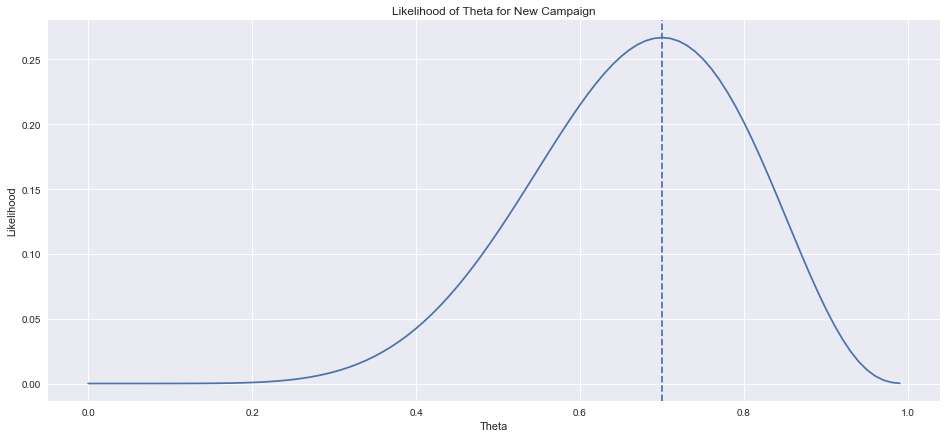

In [53]:
#evaluate the likelihood function for possible click through rates
likelihoods = likelihood(possible_theta_values, 
                         n_impressions, 
                         n_clicks)

#pick the best theta
mle = possible_theta_values[np.argmax(likelihoods)]

#plot
f, ax = plt.subplots(1)
ax.plot(possible_theta_values, likelihoods)
ax.axvline(mle, linestyle = "--")
ax.set_xlabel("Theta")
ax.set_ylabel("Likelihood")
ax.grid(True)
ax.set_title("Likelihood of Theta for New Campaign")

Of the 10 people we showed the new ad to, 7 of them clicked on it. So naturally, our likelihood function is telling us that the most likely value of theta is 0.7. However, some of our analysts are skeptical. The performance of this campaign seems extremely high given how our other campaigns have done historically. Let's overlay this likelihood function with the distribution of click-through rates from our previous 100 campaigns:

Text(0.5,1,'Evidence vs Historical Click Through Rates')

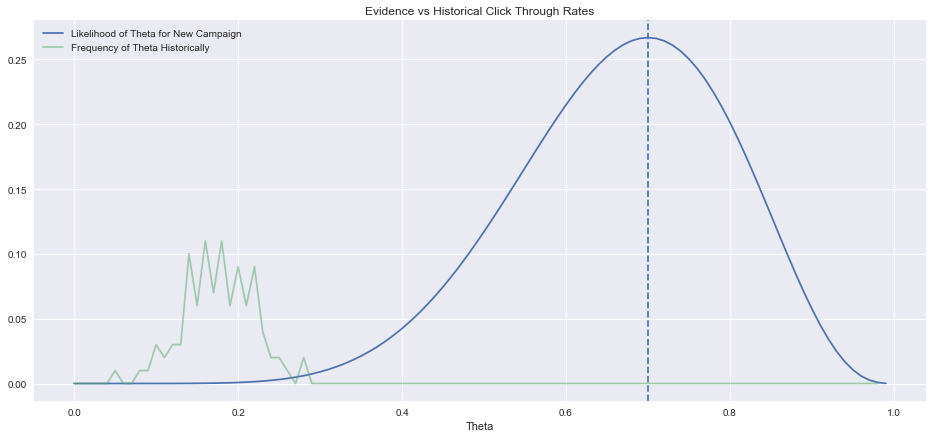

In [56]:
true_a = 11
true_b = 48

#number of marketing campaigns
N = 100 

#randomly generate "true" click through rate for each campaign
p = np.random.beta(true_a, true_b, size=N)

#randomly pick the number of impressions for each campaign
impressions = np.random.randint(1, 10000, size=N)

#sample number of clicks for each campaign
clicks = np.random.binomial(impressions, p)
click_through_rates = clicks / impressions

# Plot the new campaign
f, ax = plt.subplots(1)
ax.axvline(mle, linestyle = "--")
ax.plot(possible_theta_values, likelihoods)

counts, bins = np.histogram(click_through_rates, 
                            bins=possible_theta_values)

# Plot historical data
counts = counts / 100
ax.plot(bins[:-1], counts, alpha = .5)

line1, line2, line3 = ax.lines
ax.legend((line2, line3), ('Likelihood of Theta for New Campaign', 
                           'Frequency of Theta Historically'), 
          loc = 'upper left')
ax.set_xlabel("Theta")
ax.grid(True)
ax.set_title("Evidence vs Historical Click Through Rates")

Clearly, the maximum likelihood method is giving us a value that is outside what we would normally see. Perhaps our analysts are right to be skeptical; as the campaign continues to run, its click-through rate could decrease. Alternatively, this campaign could be truly outperforming all previous campaigns. We can't be sure. Ideally, we would rely on other campaigns' history if we had no data from our new campaign. And as we got more and more data, we would allow the new campaign data to speak for itself.

Clearly, the maximum likelihood method is giving us a value that is outside what we would normally see. Perhaps our analysts are right to be skeptical; as the campaign continues to run, its click-through rate could decrease. Alternatively, this campaign could be truly outperforming all previous campaigns. We can't be sure. Ideally, we would rely on other campaigns' history if we had no data from our new campaign. And as we got more and more data, we would allow the new campaign data to speak for itself.

The Prior Distribution
This skepticism corresponds to prior probability in Bayesian inference. Before considering any data at all, we believe that certain values of θ are more likely than others, given what we know about marketing campaigns. We believe, for instance, that p(θ = 0.2)>p(θ = 0.5), since none of our previous campaigns have had click-through rates remotely close to 0.5. We express our prior beliefs of θ with p(θ). Using historical campaigns to assess p(θ) is our choice as a researcher. Generally, prior distributions can be chosen with many goals in mind:

* Informative; empirical: We have some data from related experiments and choose to leverage that data to inform our prior beliefs. Our prior beliefs will impact our final assessment.

* Informative; non-empirical: We have some inherent reason to prefer certain values over others. For instance, if we want to regularize a regression to prevent overfitting, we might set the prior distribution of our coefficients to have decreasing probability as we move away from 0. Our prior beliefs will impact our final assessment.

* Informative; domain-knowledge: Though we do not have supporting data, we know as domain experts that certain facts are more true than others. Our prior beliefs will impact our final assessment.

* Non-informative: Our prior beliefs will have little to no effect on our final assessment. We want the data to speak for itself.

For our example, because we have related data and limited data on the new campaign, we will use an informative, empirical prior. We will choose a beta distribution for our prior for θ. The beta distribution is a 2 parameter (α, β) distribution that is often used as a prior for the θ parameter of the binomial distribution. Because we want to use our previous campaigns as the basis for our prior beliefs, we will determine α and β by fitting a beta distribution to our historical click-through rates. Below, we fit the beta distribution and compare the estimated prior distribution with previous click-through rates to ensure the two are properly aligned:

Parameters (13.260609689306026, 60.05205847076683, 0, 1)


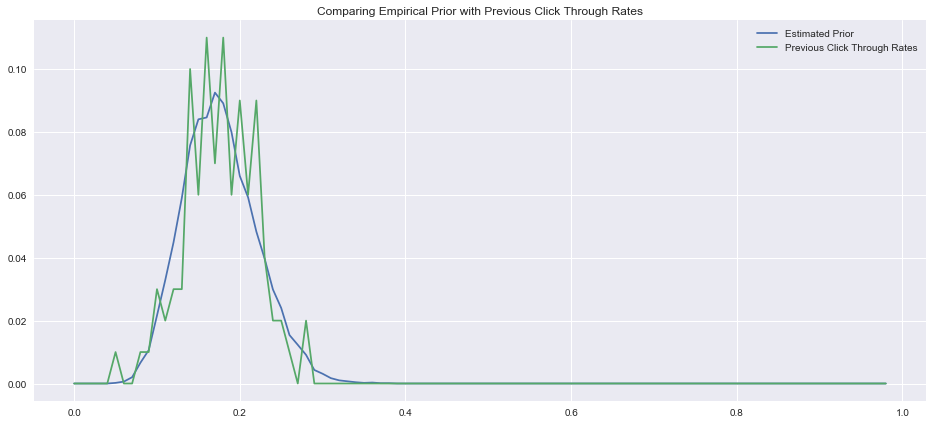

In [73]:
#fit beta to previous CTRs
prior_parameters = beta.fit(click_through_rates, 
                            floc = 0, 
                            fscale = 1)

#extract a,b from fit
prior_a, prior_b = prior_parameters[0:2]

#define prior distribution sample from prior
prior_distribution = beta(prior_a, prior_b)

#get histogram of samples
prior_samples = prior_distribution.rvs(10000)

#get histogram of samples
fit_counts, bins = np.histogram(prior_samples, 
                                possible_theta_values)

#normalize histogram
fit_counts = [float(x)/fit_counts.sum() for x in fit_counts]

#plot
f, ax = plt.subplots(1)
ax.plot(bins[:-1], fit_counts)

hist_ctr, bins = np.histogram(click_through_rates, 
                              possible_theta_values)

hist_ctr = [float(x)/hist_ctr.sum() for x in hist_ctr]

ax.plot(bins[:-1], hist_ctr)
estimated_prior, previous_click_through_rates = ax.lines
ax.legend((estimated_prior, previous_click_through_rates),
          ('Estimated Prior', 
           'Previous Click Through Rates'))
ax.grid(True)
ax.set_title("Comparing Empirical Prior with Previous Click Through Rates")

print("Parameters", prior_parameters)

### Doing Bayesian Inference with PyMC

Usually, the true posterior must be approximated with numerical methods. To see why, let's return to the definition of the posterior distribution:

$ p(\theta | X) = \frac{p(\theta) p(X | \theta)}{p(X)} $

The denominator p(X) is the total probability of observing our data under all possible values of θ. A more descriptive representation of this quantity is given by:

$\int p(\theta) p(X|\theta) d\theta$

Which sums the probability of X over all values of θ. This integral usually does not have a closed-form solution, so we need an approximation. One method of approximating our posterior is by using Markov Chain Monte Carlo (MCMC), which generates samples in a way that mimics the unknown distribution. We begin at a particular value, and "propose" another value as a sample according to a stochastic process. We may reject the sample if the proposed value seems unlikely and propose another. If we accept the proposal, we move to the new value and propose another.

The prototypical PyMC program has two components:

Define all variables, and how variables depend on each other
Run an algorithm to simulate a posterior distribution
Let's now obtain samples from the posterior. We select our prior as a Beta(13, 60). Let's see how observing 7 clicks from 10 impressions updates our beliefs:

In [74]:
import pymc3 as pm

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [86]:
#create our data:
clicks = np.array([n_clicks])
#clicks represents our successes. We observed 7 clicks.
impressions = np.array([n_impressions])
#this represents the number of trials. There were 10 impressions.

with pm.Model() as model:
#sets a context; all code in block "belongs" to the model object

    theta_prior = pm.Beta('prior', 13, 60)
    #our prior distribution, Beta (13, 60)
    observations = pm.Binomial('obs',
                               n = impressions, 
                               p = theta_prior, 
                               observed = clicks)     
    #Sampling distribition of outcomes in the dataset.
    #our prior theta_prior will be updated with data

#     start = pm.find_MAP()    
    #find good starting values for the sampling algorithm
    #Max Aposterior values, or values that are most likely

    step = pm.NUTS()     
    #Choose a particular MCMC algorithm     
    #we'll choose NUTS, the No U-Turn Sampler (Hamiltonian)

    trace = pm.sample(5000, 
                      step, 
                      start=start, 
                      progressbar=True)               #obtain samples

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:04<00:00, 2472.57draws/s]
The acceptance probability does not match the target. It is 0.8821787852538382, but should be close to 0.8. Try to increase the number of tuning steps.


Let's walk through each line of code:

with pm.Model() as model:

pm.Model creates a PyMC model object. as model assigns it to the variable name "model", and the with ... : syntax establishes a context manager. All PyMC objects created within the context manager are added to the model object.

theta_prior = pm.Beta('prior', 11.5, 48.5)

Theta_prior represents a random variable for click-through rates. It will serve as our prior distribution for the parameter θ, the click-through rate of our facebook-yellow-dress campaign. This random variable is generated from a beta distribution (pm.Beta); we name this random variable "prior" and hardcode parameter values 11.5 and 48.5. We could have set the values of these parameters as random variables as well, but we hardcode them here as they are known.

observations = pm.Binomial('obs',n = impressions , p = theta_prior , observed = clicks)

This statement represents the likelihood of the data under the model. Again we define the variable name and set parameter values with n and p. Note that for this variable, the parameter p is assigned to a random variable, indicating that we are trying to model that variable. Lastly, we provide observed instances of the variable (i.e. our data) with the observed keyword. Because we have said this variable is observed, the model will not try to change its values.

start = pm.find_MAP()

step = pm.NUTS(state=start)

trace = pm.sample(2000, step, start=start, progressbar=True)

These three lines define how we are going to sample values from the posterior. pm.find_MAP() will identify values of theta that are likely in the posterior, and will serve as the starting values for our sampler.

pm.NUTS(state=start) will determine which sampler to use. The sampling algorithm defines how we propose new samples given our current state. The proposals can be done completely randomly, in which case we'll reject samples a lot, or we can propose samples more intelligently. NUTS (short for the No-U-Turn sample) is an intelligent sampling algorithm. Other choices include Metropolis Hastings, Gibbs, and Slice sampling.

Lastly, pm.sample(2000, step, start=start, progressbar=True) will generate samples for us using the sampling algorithm and starting values defined above.

Let's take the histogram of the samples obtained from PyMC to see what the most probable values of θ are, compared with our prior distribution and the evidence (likelihood of our data for each value of θ):

Text(0.5,1,'Prior Distribution Updated with Some Evidence')

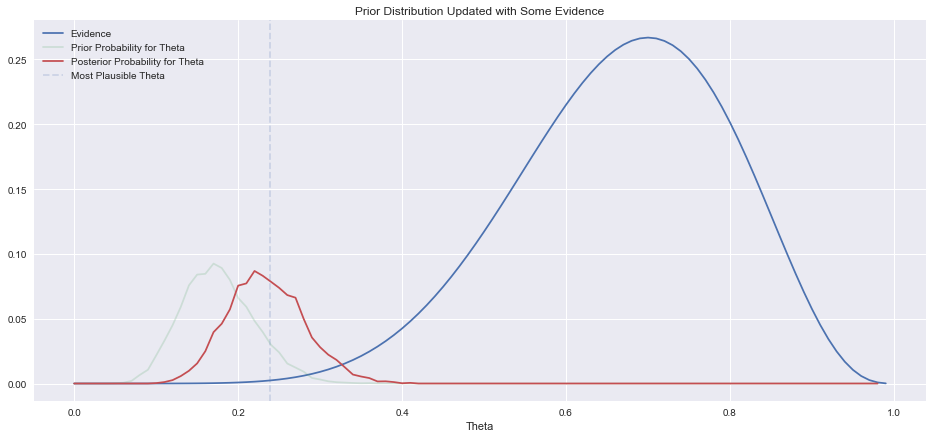

In [95]:
#get histogram of samples from posterior distribution of CTRs
posterior_counts, posterior_bins = np.histogram(trace['prior'],
                                                bins=possible_theta_values)
#normalized histogram
posterior_counts = posterior_counts / posterior_counts.sum()

#take the mean of the samples as most plausible value
most_plausible_theta = np.mean(trace['prior'])

#histogram of samples from prior distribution
prior_counts, bins = np.histogram(prior_samples, 
                                  possible_theta_values)

#normalize
prior_counts = [x/prior_counts.sum() for x in prior_counts]

#plot
f, ax = plt.subplots(1)
ax.plot(possible_theta_values, likelihoods)
ax.plot(bins[:-1],prior_counts, alpha = .2)
ax.plot(bins[:-1],posterior_counts)

ax.axvline(most_plausible_theta, linestyle = "--", alpha = .2)
line1, line2, line3, line4 = ax.lines
ax.legend((line1, line2, line3, line4), ('Evidence', 
                                         'Prior Probability for Theta', 
                                         'Posterior Probability for Theta', 
                                         'Most Plausible Theta'
                                        ), 
          loc = 'upper left')
ax.set_xlabel("Theta")
ax.grid(True)
ax.set_title("Prior Distribution Updated with Some Evidence")

In [96]:
most_plausible_theta

0.23937235079343155

logp = -5.699, ||grad|| = 4.5753: 100%|██████████| 7/7 [00:00<00:00, 1410.12it/s]
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:05<00:00, 2017.46draws/s]
The acceptance probability does not match the target. It is 0.88674744106366, but should be close to 0.8. Try to increase the number of tuning steps.
logp = -65.847, ||grad|| = 51.548: 100%|██████████| 7/7 [00:00<00:00, 1267.22it/s]
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:04<00:00, 2429.14draws/s]
INFO (theano.gof.compilelock): Refreshing lock /Users/AlexKH/.theano/compiledir_Darwin-17.7.0-x86_64-i386-64bit-i386-3.6.0-64/lock_dir/lock
logp = -657.24, ||grad|| = 521.27: 100%|██████████| 8/8 [00:00<00:00, 1371.30it/s]
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [prior]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:04<00:00, 2420.07draws/s]
logp = -6,560.8, ||grad|| = 5,218.5: 100%|██████████| 9/9

Text(0.5,1,'Posterior Shifts as Weight of Evidence Increases')

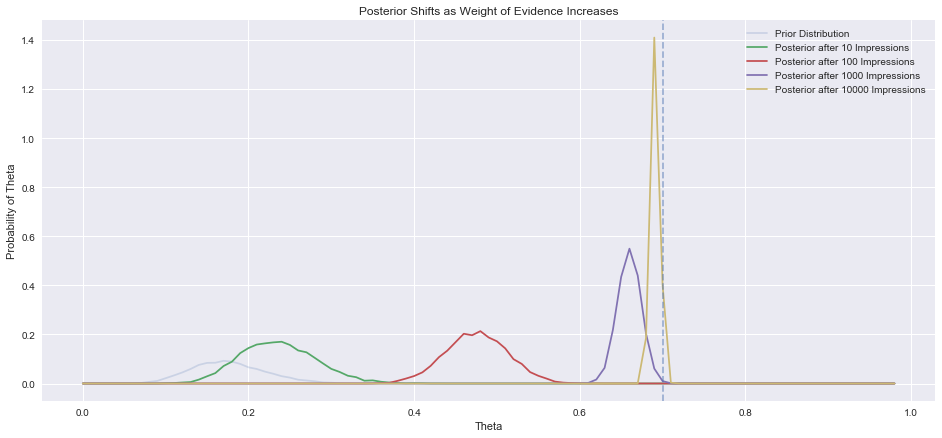

In [99]:
#create our data:
traces = {}
for ad_impressions in [10, 100, 1000, 10000]: #maintaining observed CTR of 0.7
    clicks = np.array([ctr * ad_impressions])    #re-estimate the posterior for
    impressions = np.array([ad_impressions])    #increasing numbers of impressions
    with pm.Model() as model:
        theta_prior = pm.Beta('prior', 13, 60)
        observations = pm.Binomial('obs',
                                   n = impressions, 
                                   p = theta_prior, 
                                   observed = clicks)
        start = pm.find_MAP()
        step = pm.NUTS()
        
        trace = pm.sample(5000, 
                          step, 
                          start=start, 
                          progressbar=True)

        traces[ad_impressions] = trace


f, ax = plt.subplots(1)
ax.plot(bins[:-1],prior_counts, alpha = .2)

counts = {}
for ad_impressions in [10, 100, 1000, 10000]:
    trace = traces[ad_impressions]
    posterior_counts, posterior_bins = np.histogram(trace['prior'], bins=possible_theta_values)
    posterior_counts = posterior_counts / len(trace)
    ax.plot(bins[:-1], posterior_counts)
line0, line1, line2, line3, line4 = ax.lines
ax.legend((line0, line1, line2, line3, line4), ('Prior Distribution',
                                                'Posterior after 10 Impressions', 
                                                'Posterior after 100 Impressions', 
                                                'Posterior after 1000 Impressions',
                                                'Posterior after 10000 Impressions'))
ax.set_xlabel("Theta")
ax.axvline(ctr, linestyle = "--", alpha = .5)
ax.grid(True)
ax.set_ylabel("Probability of Theta")
ax.set_title("Posterior Shifts as Weight of Evidence Increases")

As we obtain more and more data, we are more certain that the 0.7 success rate is the true success rate. Conditioning on more data as we update our prior, the likelihood function begins to play a larger role in our ultimate assessment because the weight of the evidence gets stronger. This would be particularly useful in practice if we wanted a continuous, fair assessment of how our campaigns are performing without having to worry about overfitting to a small sample.

There are a lot of concepts are beyond the scope of this tutorial, but are important for doing Bayesian analysis successfully, such as how to choose a prior, which sampling algorithm to choose, determining if the sampler is giving us good samplers, or checking for sampler convergence. Hopefully this tutorial inspires you to continue exploring the fascinating world of Bayesian inference.